In [1]:
import dataset_handler as dh
import testing_utils as tu
from termcolor import colored
import re

/home/CodeGen_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
priming_text_path = "data/priming_texts/gsm8k/codegen/func_eq_short.txt"
gsm8k_path = "data/grade-school-math/grade_school_math/data/train.jsonl"

current_dataset = dh.init_dataset_from_name(
        "gsm8k", primingtext_path=priming_text_path
    )

In [3]:
subset_data = current_dataset.data[:3000]

subset_data = [elem["question"] for elem in subset_data]

In [4]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

tu.set_all_seeds("codegen")

embedder = SentenceTransformer('all-mpnet-base-v2')

# Corpus with example sentences
corpus = subset_data
corpus_embeddings = embedder.encode(corpus)

# Perform kmean clustering
num_clusters = 6
clustering_model = KMeans(n_clusters=num_clusters, random_state=42)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(corpus[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster[0])
    print("")

Cluster  1
Julie is reading a 120-page book. Yesterday, she was able to read 12 pages and today, she read twice as many pages as yesterday. If she wants to read half of the remaining pages tomorrow, how many pages should she read?

Cluster  2
Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?

Cluster  3
A deep-sea monster rises from the waters once every hundred years to feast on a ship and sate its hunger. Over three hundred years, it has consumed 847 people. Ships have been built larger over time, so each new ship has twice as many people as the last ship. How many people were on the ship the monster ate in the first hundred years?

Cluster  4
Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?

Cluster  5
Natalia s

In [5]:
def print_colored_pos(dist_list, pos):
    for i, dist in enumerate(dist_list):
        if i == pos:
            print(colored(dist, "cyan"))

In [6]:
def extract_eq(full_answer):
    eq_pattern = re.compile(r"<<([^>]+)>>")
    split_list = re.findall(eq_pattern, full_answer)

    eq_string = ""

    for i, eq in enumerate(split_list):
        eq_string += f" eq{i+1}: {eq}"

    return eq_string

In [7]:
import numpy as np
def print_cluster_closest(cluster_id):
    d = clustering_model.transform(corpus_embeddings)[:, cluster_id]
    ind = np.argsort(d)[::][:3]
    print(list(ind))
    for ex_i,i in enumerate(ind):
        #print_colored_pos(clustering_model.transform([corpus_embeddings[i]])[0], 1)
        print( f"def exercise{ex_i+1}():\n"
            + '    """'
            + current_dataset.data[i]["question"]
            + " Hint: use these equations"
            + extract_eq(current_dataset.data[i]["answer"])
            + '"""')
        print("\n")
        current_dataset.print_entry_from_idx(i)

In [8]:
#save to a pickle the clsutering model
import pickle
with open("clustering_model_6.pkl", "wb") as f:
    pickle.dump(clustering_model, f)

In [9]:
print_cluster_closest(0)

[2232, 2759, 854]
def exercise1():
    """Adam goes to school every day. On Monday he had 6 lessons of 30 minutes each, and on Tuesday he had 3 lessons of 1 hour each. On Wednesday, Adam spent twice as much time at school as on Tuesday. How much time in total did Adam spend at school during these 3 days, in hours? Hint: use these equations eq1: 6*30=180 eq2: 2*3=6 eq3: 3+3+6=12"""


Adam goes to school every day. On Monday he had 6 lessons of 30 minutes each, and on Tuesday he had 3 lessons of 1 hour each. On Wednesday, Adam spent twice as much time at school as on Tuesday. How much time in total did Adam spend at school during these 3 days, in hours?
On Monday Adam had 6 * 30 = <<6*30=180>>180 minutes of lessons, which is 3 hours.
On Wednesday Adam spent twice as much time at school as on Tuesday, so he spent 2 * 3 = <<2*3=6>>6 hours at school.
This means that during these three days Adam spent at school 3 + 3 + 6 = <<3+3+6=12>>12 hours.
#### 12
12

-----------------------------------

In [10]:
from sklearn.decomposition import PCA

pca = PCA(2)

df = pca.fit_transform(corpus_embeddings)

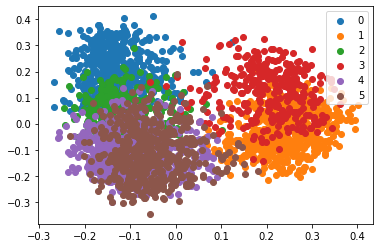

In [11]:
import matplotlib.pyplot as plt
#kmeans = KMeans(n_clusters= 8, random_state=0)
 
#predict the labels of clusters.
#label = kmeans.fit_predict(df)
 
#Getting unique labels
u_labels = np.unique(cluster_assignment)
 
#plotting the results:
for i in u_labels:
    plt.scatter(df[cluster_assignment == i , 0] , df[cluster_assignment == i , 1] , label = i)
plt.legend()
plt.show()